# Simple Detection Evaluation 

### Leval 1. Binary Evaluation - Species Present vs Not-Present in image
**Evaluating the performance of object detector on classifying task, i.e - performance on finding the species in images**

1. Overall Level
2. Species level

### Level 2. Species Count 
1. Overall level
2. Speceis level
3. Count level

### Level 3. Incorporate IoU
[Look at this when writing](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

## Level 1:
1. Filter out the images that were not user for model training
2. Make predictions on these images
    - wait, we can run the predictions on all the image and then do the step 1
3. Run the queries - predictorExtractor_main.py and prediction_groundtruth_consolidation_main.py
4. Evaluate predictions

In [2]:
# importing the necessary librabies
import csv, glob
import pandas as pd
import numpy as np
import sklearn.metrics as metric
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

In [21]:
# Working with the older dataset for building this
filepath = "/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/round1/pred_groundtruth_consolidate_snapshot_serengeti_s01_s06_0_199999-00000-of-00100.csv"
df_pred_gt_consolidated = pd.read_csv(filepath)
df_pred_gt_consolidated = df_pred_gt_consolidated.fillna(0)
df_pred_gt_consolidated.tail()

,filename,species,labels,groundtruth_counts,prediction_counts
3638,S6/V10/V10_R1/S6_V10_R1_IMAG0574,impala,10,0,1
3639,S6/V10/V10_R1/S6_V10_R1_IMAG1213,elephant,11,0,1
3640,S6/V10/V10_R1/S6_V10_R1_IMAG1213,buffalo,14,0,1
3641,S6/V10/V10_R1/S6_V10_R1_IMAG1373,hartebeest,15,0,1
3642,S6/V10/V10_R1/S6_V10_R1_IMAG1373,lionFemale,20,0,1


In [15]:
# Consolidate all the prediction_groundtruth shards
filepath_list = glob.glob("/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/round1/pred_groundtruth_consolidate_snapshot_serengeti_s01_s06*")
def combine_pred_groundtruth_consolidated_files(filepath_list):
    """This function combines all the small shards pred_groundtruth_consolidate_snapshot_serengeti_s01_s06
    into a big file.
    Parameter: filepath for the pred_groundtruth_consolidate_snapshot_serengeti_s01_s06*
    Return: consolidated datframe
    """
    df_pred_gt_consolidated = pd.DataFrame()
    list_temp = []
    for i, filepath in enumerate(filepath_list):
        df_pred_gt_temp = pd.read_csv(filepath)
        df_pred_gt_temp = df_pred_gt_temp.fillna(0)
        list_temp.append(df_pred_gt_temp.shape[0]) # for use to check the correct append. len(list_temp)== 400
        df_pred_gt_consolidated = df_pred_gt_consolidated.append(df_pred_gt_temp)
    return df_pred_gt_consolidated

In [16]:
df_pred_gt_consolidated = combine_pred_groundtruth_consolidated_files(filepath_list)
df_pred_gt_consolidated.tail()

400
1395864
1395864


,filename,species,labels,groundtruth_counts,prediction_counts
3579,S6/U10/U10_R2/S6_U10_R2_IMAG1408,wildebeest,17,0,1
3580,S6/U11/U11_R2/S6_U11_R2_IMAG0183,elephant,11,0,1
3581,S6/U11/U11_R2/S6_U11_R2_IMAG0183,wildebeest,17,0,1
3582,S6/U12/U12_R1/S6_U12_R1_IMAG0320,elephant,11,0,1
3583,S6/U12/U12_R1/S6_U12_R1_IMAG0369,elephant,11,0,1


### Level 1:

In [17]:
y_true = [val != 0 for val in df_pred_gt_consolidated["groundtruth_counts"]]
y_pred = [val != 0 for val in df_pred_gt_consolidated["prediction_counts"]]
print(sum(y_true), sum(y_pred))

814114 1287168


In [18]:
tn, fp, fn, tp = metric.confusion_matrix(y_true, y_pred).ravel()
print(metric.confusion_matrix(y_true, y_pred))
print(tn, fp, fn, tp)

[[     0 581750]
 [108696 705418]]
0 581750 108696 705418


In [19]:
# For a classification task the recall is:
recall = round(tp/(tp + fn), 3)
precision = round(tp/(tp + fp), 3)
accuracy = round((tp+tn)/(tp + fn + fp + tn), 3)
f1_score = round(2*recall*precision/(recall + precision), 3)

print("Recall: {0}".format(recall))
print("Precision: {0}".format(precision))
print("F1-Score: {0}".format(f1_score))
print("Accuracy: {0}".format(accuracy))
      

Recall: 0.866
Precision: 0.548
F1-Score: 0.671
Accuracy: 0.505


Confusion matrix, without normalization
[[     0 581750]
 [108696 705418]]


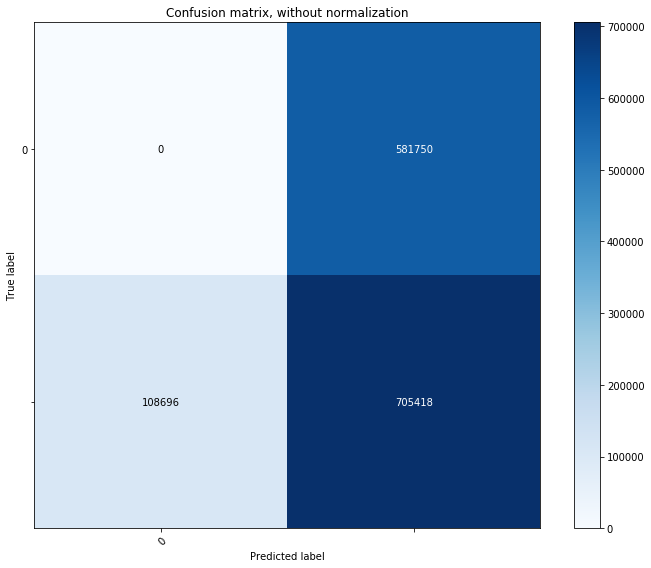

In [23]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metric.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=np.array(['1', '0']),
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plot_confusion_matrix(y_true, y_pred, classes=np.array(['false', 'true']), normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

## Level 2.

In [24]:
for species in set(df_pred_gt_consolidated['species']):
    error = False
    print(species)
    df_temp = df_pred_gt_consolidated[df_pred_gt_consolidated['species']==species]
    y_true = [val != 0 for val in df_temp["groundtruth_counts"]]
    y_pred = [val != 0 for val in df_temp["prediction_counts"]]
    try:
        tn, fp, fn, tp = metric.confusion_matrix(y_true, y_pred).ravel()
    except Exception:
#         y_true = [2] # to know why this exception run this code
#         y_pred = [2]
#         int(confusion_matrix(y_true, y_pred))
        tn, fp, fn, tp = 0, 0, 0, int(metric.confusion_matrix(y_true, y_pred))
        pass

    recall = round(tp/(tp + fn), 3)
    precision = round(tp/(tp + fp), 3)
    accuracy = round((tp+tn)/(tp + fn + fp + tn), 3)
    f1_score = round(2*recall*precision/(recall + precision), 3)
    print(metric.confusion_matrix(y_true, y_pred))
    print("Recall: {0}".format(recall))
    print("Precision: {0}".format(precision))
    print("F1-Score: {0}".format(f1_score))
    print("Accuracy: {0}".format(accuracy))
    print("\n")

lionMale
[[    0 12942]
 [  143   525]]
Recall: 0.786
Precision: 0.039
F1-Score: 0.074
Accuracy: 0.039


batEaredFox
[[  0 701]
 [133 256]]
Recall: 0.658
Precision: 0.268
F1-Score: 0.381
Accuracy: 0.235


buffalo
[[    0 74293]
 [ 5566 27406]]
Recall: 0.831
Precision: 0.269
F1-Score: 0.406
Accuracy: 0.255


serval
[[  0 958]
 [187 353]]
Recall: 0.654
Precision: 0.269
F1-Score: 0.381
Accuracy: 0.236


gazelleThomsons
[[    0 16833]
 [14790 99553]]
Recall: 0.871
Precision: 0.855
F1-Score: 0.863
Accuracy: 0.759


zebra
[[     0  19410]
 [ 11273 166583]]
Recall: 0.937
Precision: 0.896
F1-Score: 0.916
Accuracy: 0.844


bushbuck
[[  0 165]
 [186  73]]
Recall: 0.282
Precision: 0.307
F1-Score: 0.294
Accuracy: 0.172


koriBustard
[[   0 3172]
 [ 515  995]]
Recall: 0.659
Precision: 0.239
F1-Score: 0.351
Accuracy: 0.213


topi
[[    0 30903]
 [ 1526  4006]]
Recall: 0.724
Precision: 0.115
F1-Score: 0.198
Accuracy: 0.11


dikDik
[[   0 5397]
 [1282 1519]]
Recall: 0.542
Precision: 0.22
F1-Score: 0.3

/home/ubuntu/test_env/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


[[ 0 27]
 [18  0]]
Recall: 0.0
Precision: 0.0
F1-Score: nan
Accuracy: 0.0


aardwolf
[[ 0 61]
 [40 64]]
Recall: 0.615
Precision: 0.512
F1-Score: 0.559
Accuracy: 0.388


reptiles
[[  0  89]
 [337  11]]
Recall: 0.032
Precision: 0.11
F1-Score: 0.05
Accuracy: 0.025


vervetMonkey
[[   0 1779]
 [ 372  415]]
Recall: 0.527
Precision: 0.189
F1-Score: 0.278
Accuracy: 0.162


porcupine
[[  0 308]
 [ 15 198]]
Recall: 0.93
Precision: 0.391
F1-Score: 0.551
Accuracy: 0.38


reedbuck
[[   0 2548]
 [1351 2178]]
Recall: 0.617
Precision: 0.461
F1-Score: 0.528
Accuracy: 0.358


hartebeest
[[    0 29913]
 [ 9990 23706]]
Recall: 0.704
Precision: 0.442
F1-Score: 0.543
Accuracy: 0.373


human
[[   0 3565]
 [ 290   16]]
Recall: 0.052
Precision: 0.004
F1-Score: 0.007
Accuracy: 0.004


hare
[[  0 698]
 [109 451]]
Recall: 0.805
Precision: 0.393
F1-Score: 0.528
Accuracy: 0.359


ostrich
[[   0 7042]
 [ 228 1016]]
Recall: 0.817
Precision: 0.126
F1-Score: 0.218
Accuracy: 0.123


genet
[[ 0 25]
 [ 9  0]]
Recall: 0.0